# #winerec - A Wine Recommendation System

This notebook presents the code necessary to build the wine recommendation system. Its purpose is to show the process, explain and document the decisions taken and demonstrate the sytem.

## Organization of the Notebook

The organization of the notebook follows the different steps undertaken to create the recommendation system:

1. Data Exploration: source of the data, the different variables and exploratory plots
2. Data Processing:
    1. Data selection, filtering and handling of missing values
    2. Tokenization and cleaning of the text descriptions
3. Data Understanding
4. Testing Different Recommendation Systems
5. Conclusion

In [1]:
# IMPORTING THE NECESSARY PACKAGES AND FUNCTIONS:

# generic:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time 

# more specific:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer # Normalize samples individually to unit norm.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pickle # to save models, for instance LDA outputs

# NLP:
import spacy # version 2.2.1 
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD # LSA
from sklearn.decomposition import NMF # NMF
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis # used to visualize and plot ouptut of LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


## 1. Data Exploration

The [dataset](https://www.kaggle.com/zynicide/wine-reviews) was uploaded on Kaggle by Zack Thout. It consists of 140’000 wine reviews scraped from the [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) magazine website. I use a new version of the dataset, extracted on March 2019 (c.f. [discussion](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970)) and found [here](https://www.kaggle.com/zynicide/wine-reviews/discussion/83970).  

We first explore the data. The observations will guide the next data processing steps.

In [2]:
# load data: 
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
initial_number_of_rows = raw_winedata.shape[0]
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [3]:
# variables types:
raw_winedata.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
vintage                  float64
dtype: object

In [4]:
# checking for missing values:
raw_winedata.isnull().sum()

country                     61
description                  0
designation              40182
points                       0
price                     9658
province                    61
region_1                 22886
region_2                 86832
taster_name              24917
taster_twitter_handle    30649
title                        0
variety                      1
winery                       0
vintage                   5234
dtype: int64

### Variables in the Dataset

|variable|short explanation|
|--------|-----------------|
|country|The country that the wine is from|
|description|Wine description by a _sommelier_, identified in the column "taster"|
|designation|The vineyard within the winery where the grapes that made the wine are from|
|points|The number of points WineEnthusiast rated the wine on a scale of 80-100 (wines deemed unacceptable (rating < 80) are not reviewed)|
|price|The cost for a bottle of the wine in USD |
|province|The province or state that the wine is from|
|region_1|The wine growing area in a province or state (e.g. Napa)|
|region_2|Sometimes there are more specific regions specified within a wine growing area (e.g. Rutherford inside the Napa Valley)|
|taster_name|Name of the _sommelier_ who wrote the description|
|taster_twitter_handle| |
|title|The title of the wine review|
|variety|The type of grapes used to make the wine (e.g. Pinot Noir)|
|winery|The winery that made the wine|
|vintage|Extracted from "title" when present|

We then have a look at the most important variables.

#### Description

The variable that interest us the most is the variable _description_, as we will base our content-based recommendation system on it. There are no missing values, however some descriptions are duplicated:

In [5]:
# inspect duplicated description:
duplicates_description  = raw_winedata[raw_winedata.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)
# duplicates_description # if want to print duplicates

# note: there are no full duplicates of row:
# duplicates = raw_winedata[raw_winedata.duplicated()] # is empty

number of duplicated descriptions:  38.0


No rows are full duplicates. However, 38 descriptions occur twice. Usually the descriptions occuring twice are two different wines coming from the same region. Sometimes even from the same winery, but with a different designation (e.g. "reserve"). We cannot know if these duplicate descriptions are valid tasting description or copy-paste errors from the tasters. Thus, we could keep them and assume that the taster did voluntarily copy their description because the wine was indeed very similar. However we have to keep in mind that if two descriptions are exact copies, the similarity distance that we will compute, or tf-idf scores or topics, or actually any measure will be the same.  

To stay on the safe side, we will remove these duplicates when processing data.

In [6]:
# Some examples of descriptions:
for i in range(1,5):
    print(raw_winedata.description[i], '\n')

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. 

Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish. 

Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew. 



Already with this very small subset, we note that not all words or sentences used are directly related to taste. For instance: "although it will certainly be better from 2016" or "Much like the regular bottling from 2012". 

Number of characters in the longest descritption:  829 ; and in the shortest:  20 . The mean is  242.97805348227968  and the median 237.0


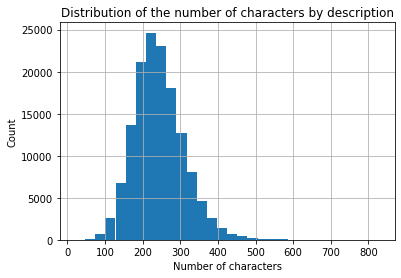

In [7]:
# length of the descriptions:
descr_lengths = raw_winedata.description.apply(len)
print("Number of characters in the longest descritption: ", max(descr_lengths), 
      '; and in the shortest: ', min(descr_lengths), '. The mean is ',
     np.mean(descr_lengths), ' and the median', np.median(descr_lengths))
# distribution: 
raw_winedata.description.apply(len).hist(bins=30)
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.title('Distribution of the number of characters by description')
plt.show()

We will remove descriptions with less than 100 characters because we consider that they do not carry enough information to be useful for NLP.

In [8]:
# # Use this code to print the short descriptions
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
# for descr in short_descr:
#     print(descr)

After visual inspection, we found that short descriptions usually still carry relevant information, thus we will only get rid of the descriptions that are under 45 characters long.  

We can quickly have a look at the most frequent words used:

In [9]:
# Tokenization
# Note: we do not care here much about the details of the parameters,
# we just want to have a look at the most common words: 
vectorizer = CountVectorizer(analyzer='word',       
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             max_features=1000,             # max number of unique words
                            )

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print(get_top_n_words(raw_winedata['description'], 100))

[('wine', 88822), ('flavors', 68104), ('fruit', 54225), ('palate', 45084), ('aromas', 45055), ('acidity', 39090), ('finish', 38132), ('tannins', 35255), ('drink', 34930), ('black', 32737), ('cherry', 32237), ('ripe', 30574), ('red', 24253), ('spice', 21223), ('notes', 20654), ('nose', 20166), ('oak', 19383), ('rich', 19284), ('fresh', 18996), ('berry', 18963), ('dry', 18143), ('plum', 16635), ('apple', 15162), ('fruits', 14888), ('white', 14585), ('soft', 14472), ('offers', 14298), ('light', 14253), ('blend', 14128), ('texture', 14034), ('blackberry', 13768), ('sweet', 13713), ('crisp', 13666), ('dark', 13604), ('bodied', 13356), ('citrus', 12873), ('bright', 12222), ('shows', 12119), ('vanilla', 11766), ('juicy', 11249), ('cabernet', 11245), ('lemon', 11240), ('pepper', 11233), ('green', 10533), ('fruity', 10422), ('raspberry', 10369), ('firm', 10253), ('good', 10065), ('balanced', 9594), ('peach', 9398), ('touch', 9321), ('dried', 9263), ('chocolate', 8987), ('pear', 8871), ('charact

This looks quite promising, as most of those words are taste descriptors. 

#### Country

In [10]:
def my_barplot(dataframe, variable, title=None, xlabel=None, ylabel=None, fig_height=6):
    """
        bar plot of the value counts a variable in a df.
        includes NAs, as !MISSING! in the plots
    """
    plt.figure(figsize=(6,fig_height))
    
    df_toplot = pd.DataFrame(dataframe[variable].value_counts(dropna=False).reset_index(level=0))
    df_toplot.columns = ['variable', 'count']
    # necessary for the NaN to appear on the plots:
    df_toplot['variable'] = np.where(df_toplot['variable'].isnull(), '!MISSING!', df_toplot['variable'])
    
    sns.barplot(x='count', y='variable', data=df_toplot, color="steelblue")
    plt.title(title)
    plt.ylabel(variable)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()

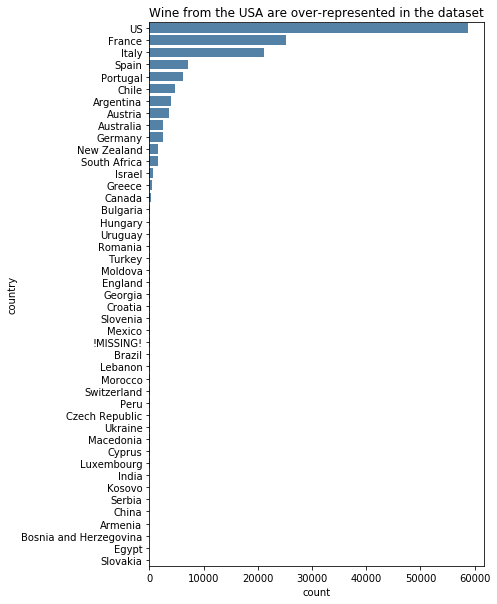

In [11]:
my_barplot(raw_winedata, 'country', title='Wine from the USA are over-represented in the dataset', fig_height=10)

#### Variety

There are 758 different varieties in the dataset
If we keep only the varieties represented by 500 wines or more, 
we still have 122856 wines in the dataset, and 42 unique varieties:


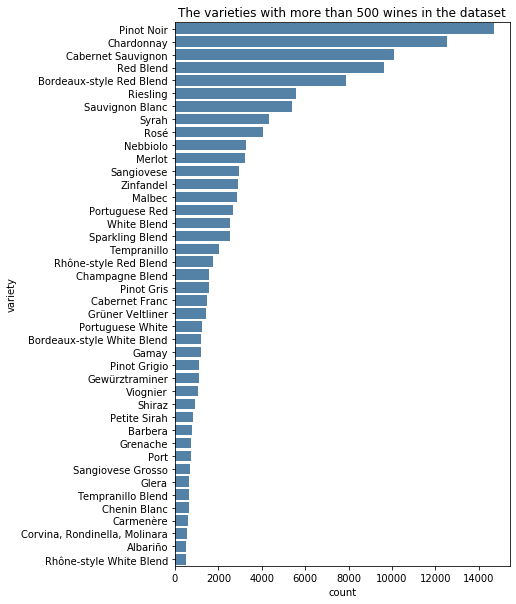

In [12]:
threshold_n_wines = 500
variety_counts = raw_winedata.variety.value_counts()

print('There are', raw_winedata.variety.nunique(), 'different varieties in the dataset')
print('If we keep only the varieties represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])].variety.nunique(),
     'unique varieties:')

my_barplot(raw_winedata[raw_winedata.variety.isin(variety_counts.index[variety_counts > threshold_n_wines])], 
           'variety', 
           title='The varieties with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


#### Province

There are 456 different provinces in the dataset
If we keep only the provinces represented by 500 wines or more, 
we still have 124904 wines in the dataset, and 41 unique provinces:


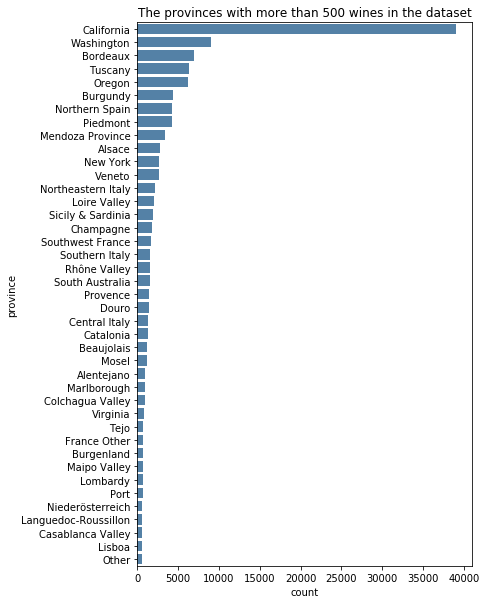

In [13]:
threshold_n_wines = 500
province_counts = raw_winedata.province.value_counts()

print('There are', raw_winedata.province.nunique(), 'different provinces in the dataset')
print('If we keep only the provinces represented by', threshold_n_wines, 'wines or more, ')
print('we still have', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].shape[0],
     'wines in the dataset, and', 
     raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])].province.nunique(),
     'unique provinces:')

my_barplot(raw_winedata[raw_winedata.province.isin(province_counts.index[province_counts > threshold_n_wines])], 
           'province', 
           title='The provinces with more than '+str(threshold_n_wines)+' wines in the dataset', 
           fig_height=10)


We note that there is a province named "Other". All those wines are coming from Argentina:

In [14]:
raw_winedata[raw_winedata.province == 'Other'].country.value_counts()

Argentina    546
Name: country, dtype: int64

There is one other province in Argentina, Mendoza:

In [15]:
raw_winedata[raw_winedata.country == 'Argentina'].province.value_counts()

Mendoza Province    3451
Other                546
Name: province, dtype: int64

Thus, we will rename the province "Other" to "Argentina Other" during the data processing step below.

#### Taster

Unfortunately a large portion of the data lack a tester name. This has to be kept in mind if we want to check the assumption that their is an "universal" way of describing wine and that vocabulary of the different taster is similar.  

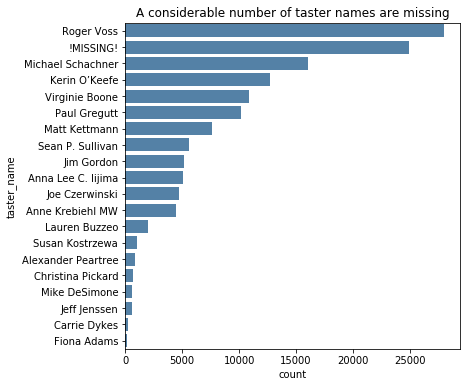

In [16]:
my_barplot(raw_winedata, 'taster_name', title='A considerable number of taster names are missing', fig_height=6)

The variables that we just explored are the most significant for this project. Let's have a quick look at the points attributed to the wine.

#### Points

Note that wines with a review less than 80 points are not reviewed, thus not in the dataset. An alternative project with this dataset could be to try to predict the points based on the text descriptions.  

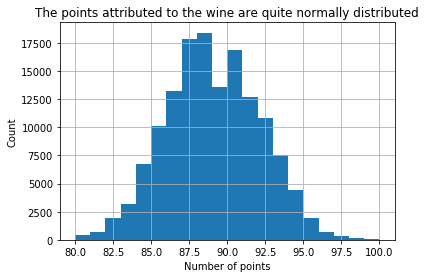

In [17]:
# distribution of points attributed to the wines:
raw_winedata.points.hist(bins=20)
plt.xlabel('Number of points')
plt.ylabel('Count')
plt.title('The points attributed to the wine are quite normally distributed')
plt.show()

**This dataset is a sample that is not representative of the wine production in the world**. It only represent what was could be scraped on the WineEnthusiast website, which is aimed at the american wine market. There is thus an important sampling bias in this dataset. More will be commented on this in the presentation.


## 2. Data Processing

In this step, we process, filter and clean the data. The data processing decisions are based on the initial data exploration, but also on later steps in the analysis pipeline.  

### 2.A. Data selection, filtering and handling of missing values

In [18]:
# creation of a dataframe that will contain the processed data:
winedata_processing = raw_winedata.copy()
initial_number_of_rows = winedata_processing.shape[0]

# WARNING: the following code chunks need to be run starting from this one !

In [19]:
# Keep only varieties that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
variety_counts = winedata_processing.variety.value_counts()
winedata_processing = winedata_processing[winedata_processing.variety.isin(variety_counts.index[variety_counts.gt(n)])] # pandas.DataFrame.gt = get greater

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])


Number of rows removed:  18761 . New number of rows: 122856


In [20]:
# Renaming the province "Other" to "Argentina Other":
winedata_processing.loc[:,'province'] = np.where(winedata_processing.province == 'Other', 
                                                'Argentina Other',
                                                winedata_processing.province)

In [21]:
# Keep only provinces that occur more than 500 times:
old_number_of_rows = winedata_processing.shape[0]

n = 500
province_counts = winedata_processing.province.value_counts()
winedata_processing = winedata_processing[winedata_processing.province.isin(province_counts.index[province_counts.gt(n)])]

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  15932 . New number of rows: 106924


In [22]:
# Remove duplicate descriptions:
old_number_of_rows = winedata_processing.shape[0]

# Note: we are conservative, and do not keep any version of the duplicates
winedata_processing = winedata_processing.drop_duplicates(subset='description', keep=False)

new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  44 . New number of rows: 106880


In [23]:
# remove descrptions that are shorter than 45 characters long:
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.description.apply(len) > 45]
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0])

Number of rows removed:  7 . New number of rows: 106873


In [24]:
# remove wines coming from the province "other":
old_number_of_rows = winedata_processing.shape[0]

winedata_processing = winedata_processing[winedata_processing.province != 'Other']
# short_descr = raw_winedata[raw_winedata.description.apply(len) < 45].description
new_number_of_rows = winedata_processing.shape[0]
print('Number of rows removed: ', old_number_of_rows-new_number_of_rows, 
      '. New number of rows:', winedata_processing.shape[0],
     '. They were apparently already removed with during the previous cleaning steps.')

Number of rows removed:  0 . New number of rows: 106873 . They were apparently already removed with during the previous cleaning steps.


In [25]:
# We drop the columns "taster_twitter_handle" and "vintage",
# as they are useless for this analysis
winedata_processing.drop(['taster_twitter_handle', 'vintage'], axis=1, inplace=True)

In [26]:
# finally, we save the processed data in a new dataframe, that we will use for the rest of the project:
winedata = winedata_processing.copy()

# and we reset the indexes of the data:
winedata.reset_index(inplace=True)

In [27]:
print("We have now a dataset of", winedata.shape[0], 'rows with', 
      winedata.shape[1], 'features.')

We have now a dataset of 106873 rows with 13 features.


### 2.B. Tokenization and cleaning of the text descriptions

We add a new column in the dataframe with the tokenized and clean descriptions, using a custom tokenizer.    

The corpus-specific stopwords (domain_specific_stopwords, variety_stopwords, province_stopwords) listed below have been updated after an initial iteration of building the recommendation system and the observations collected.  Notably, we would prefer to not have wine varieties and province inside the text descriptions, as our goal is to recommand wines based on the taste description.  

In [28]:
domain_specific_stopwords = ['$', ' ', '’s', 'wine', 'winemaker', 'winemaking', 'winery',
                             'château', 'village', 'domaine',
                             'côte', 'saint', 'village', 'parcel', 'parcels',
                             'I', 'flavors', 'vineyard', 'vintage',
                             'now-2015', 'now-2018', 'now-2025']
# Other potential words to consider removing:
# douro, nacional, widely, muscat, willamette, bordeaux, pommard, rioja, barbaresco, chianti...

# a list of all wine varieties. this is not perfect as some varieties are compound words. But it's a start.
variety_stopwords = winedata.variety.unique().tolist()
variety_stopwords = [str(variety).lower() for variety in variety_stopwords] # convert to lowercase
# we add some notable varieties to the list:
variety_stopwords = variety_stopwords + ['pinot', 'gris', 'noir', 'grigio', 'cabernet', 
                                         'cabernets', 'sauvignon', 'sirah', 'tempranillo', 
                                         'chenin', 'sangiovese', 'grüner', 'veltliner', 'corvina', 
                                         'rondinella', 'molinara', 'franc', 'blanc', 'blend',
                                         'franc', 'mourvèdre']

# a list of all wine provinces. 
province_stopwords = winedata.province.unique().tolist()
province_stopwords = [str(province).lower() for province in province_stopwords] # convert to lowercase
# we add some notable province-related words to the list:
province_stopwords = province_stopwords + ['france', 'sicily', 'sardinia', 'mendoza', 'spain', 
                                           'australia', 'italy', 'loire', 'beaujolais']


In [29]:
# Standard model used for tokenization.
# When using another model, we will have to load it and redefine "nlp"

# We do not need word vectors here, so we can upload the small English model from spaCy:
# We do not need PoS tags, dependencies or named entities, so we disable them (run faster!):
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

In [30]:
def tokenize_and_clean(description):
    """
        Our basic tokenizer function. It takes as input:
            - a pd.Series of the descriptions
            - a nlp model
        After tokenizing, it cleans the data too,
        and returns a list of tokens. 
    """
    
#     # eventually clean the description with regular expressions here:
#     pattern = "[\[].*?[\]]" # an example of an regex
#     description = re.sub(pattern, "", description) # remove this pattern from description.

    # Tokenize:
    mytokens = nlp(description)

    # Removing stopwords, punctuation, numbers and convert to lower_case
    mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop and not token.like_num and not token.is_digit]
    
    # remove domain-specific stopwords:
    mytokens = [token for token in mytokens if token not in domain_specific_stopwords]
            
    # remove wine variety occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in variety_stopwords]
    
    # remove wine province occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in province_stopwords]
                
    # Return preprocessed list of tokens
    return mytokens


In [31]:
# Tokenization:
time0 = time.time()

# we store our tokenized descriptions in a new column of the dataframe, 
# in the form of a list of words,
# which we will be able to use later in the analysis as input for different algorithms.

winedata.loc[:,'tokenized_descriptions'] = winedata.description.apply(tokenize_and_clean)

print('Done! Tokenization took', time.time()-time0, 'seconds.')

Done! Tokenization took 25.710138082504272 seconds.


In [32]:
def concatenate_list_of_words_in_one_string(list_of_words):
    """
        build one string with a list of words, with a space in the middle
    """
    return " ".join(list_of_words)

In [33]:
# we also store our tokenized descriptions as one string, 
# as it will be useful later, e.g. to compute tf-ifd.
winedata.loc[:,'token_descr_as_string'] = winedata.tokenized_descriptions.apply(
    concatenate_list_of_words_in_one_string)


In [34]:
# a csv where we save our processed data:
winedata.to_csv(path_or_buf='../data/winedata_processed_and_tokenized.csv', index=False)

## 3. Understanding the Data

We apply some supervised learning techniques to better understand the data and test some of our assumptions before building the recommender system.

### 3.A Classification Based on the Descriptions

For building this content-based system based on the tasting descriptions, we make the assumption that these descriptions written by _sommeliers_ add more information about the taste of a wine than the variety and origin of the wines. If this is the case, we should not be able to build a model with 100% accuracy when predicting the _variety_ or _province_ of the wines based on the descriptions. This is an assumption that we will test.  

As that is not the main exercise of the project, we will only test one model and will not try to fine-tune it for days:  

#### A gradient-boosting model to classify wine varieties, provinces or taster names based on unigram tf-idf vectors

We choose the gradient booting approach, as it allows the estimation of the relative importance of the features. This information might be useful later when building the recommendation system.  

In [35]:
# vectorization:
time0 = time.time()

# we only keep 500 features:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), # 1-gram
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=10, # ignore terms that have a doc freq lower than threshold.
                               max_features=500, # max number of features
                               use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                               norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                               smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                              )
# Applying the vectorizer on the "clean" descriptions:
wine_tfidf = tfidf_vectorizer.fit_transform(winedata.token_descr_as_string)

# list of features
terms = tfidf_vectorizer.get_feature_names()

# store the features in a dataframe:
tf_idf_features = pd.DataFrame(wine_tfidf.toarray(), columns=terms)

# add the different labels that interest us (indexes are the same):
tf_idf_features.loc[:, 'variety'] = winedata.variety
tf_idf_features.loc[:, 'province'] = winedata.province
tf_idf_features.loc[:, 'taster_name'] = winedata.taster_name

print('Done! Vectorization took', time.time()-time0, 'seconds.')


Done! Vectorization took 4.947460174560547 seconds.


In [36]:
# Predicting the variety:

# As gradient boosting is quite time consuming, we will use only 50% of our dataset:
tf_idf_features_sample = tf_idf_features.sample(frac=0.5, random_state=42)

Y = tf_idf_features_sample.variety
X = tf_idf_features_sample.drop(['variety', 'province', 'taster_name'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=51)

In [37]:
# # Training the Gradient Boosting: !!! TAKES VERY LONG !!!
# time0 = time.time()

# gb = GradientBoostingClassifier() # default parameters (!)
# gb.fit(X_train, y_train) # train

# print('Done! Training took', time.time()-time0, 'seconds.')

# # Evaluating the model on train set:
# y_pred = gb.predict(X_train)
# print(classification_report(y_train, y_pred))


In [38]:
# # save the gb model:
# pkl_filename = '../data/gb_tfidf_variety.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(gb, file)

In [39]:
# Load the previously trained gradient boost model:
pkl_filename = "../data/gb_tfidf_variety.pkl"
with open(pkl_filename, 'rb') as file:
    gb = pickle.load(file)

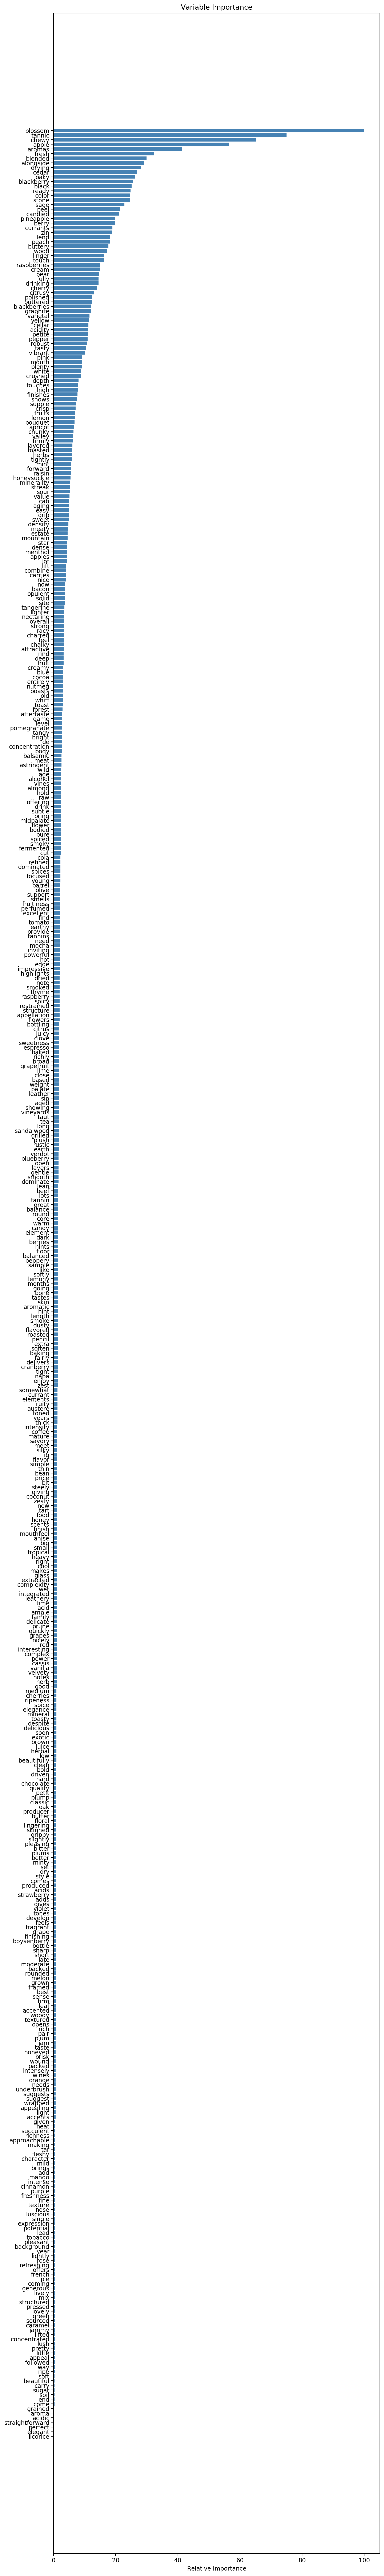

In [40]:
feature_importance = gb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.figure(figsize=(10,100), dpi=200)
plt.figure(figsize=(10,80), dpi=200)
# plt.figure(num=None, figsize=(4, 4), dpi=200, facecolor='w')
plt.barh(pos, feature_importance[sorted_idx], align='center', color='steelblue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 3.B Clustering the Descriptions



In [41]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)